In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
import IPython.display as ipd
import librosa.display

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F

from routines import *

import warnings
warnings.filterwarnings('ignore')

In [181]:
#load data
f_s=8000
x, sr = librosa.load('orchestra/pfiife.mp3',sr=f_s,duration=5)
print(x.shape)

(40000,)


stepsize: 80


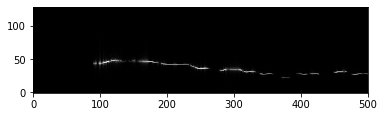

In [182]:
#calculate spectrogram
time_step=0.01#ms
N=256
ns=int(time_step*f_s)
print('stepsize: '+str(ns))
#---classical STFT
c_STFT=classic_STFT(ns=ns,N=N)
c_spec=c_STFT.get_energy_spec(x,verbose=False)*10**2#experimentally a good factor for energy conversion to the logp1 metric
plt.imshow(np.log(c_spec+1),origin='lower', cmap='gray')
plt.show()

In [196]:
#"pendulum voices": introduce sinus sound
n_pendulum=int(N/2)+1
max_freq=f_s/3
df=max_freq/n_pendulum
pendulum_source=np.zeros((n_pendulum,x.shape[0]))
pendulum_amplitudes=pendulum_source.copy()
sample_idx=np.linspace(0, x.shape[0]-1, num=x.shape[0])
for p in range(n_pendulum):
    w_p=2*np.pi*p*df/f_s#we include the zero frequency
    pendulum_source[p,:]=np.sin(w_p*sample_idx)/n_pendulum
pendulum_amplitudes[10,:]=1
pendulum_amplitudes[20,10000:25000]=1
pendulum_amplitudes[25,15000:20000]=0.75

pendulum_orchestra=pendulum_amplitudes*pendulum_source
pendulum_mix=np.sum(pendulum_orchestra,axis=0)




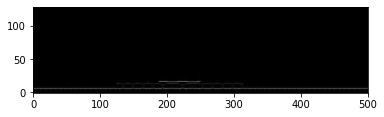

In [184]:
#---classical STFT of pendulum mix
c_spec=c_STFT.get_energy_spec(pendulum_mix,verbose=False)*10**2#experimentally a good factor for energy conversion to the logp1 metric
plt.imshow(np.log(c_spec+1),origin='lower', cmap='gray')
plt.show()
librosa.output.write_wav('orchestra/pendulum_mix.mp3', pendulum_mix, f_s)

In [185]:
def get_spec_col(y):
    #y is a 1-d (real) signal
    #need to expand it into the complex plain for using torch.fft
    N=y.size(0)
    window=get_gaussian_window(N)
    z=torch.zeros(N,2)
    z[:,0]=y*window
    z_hat=torch.fft(z,1)
    e=torch.sum(torch.mul(z_hat,z_hat),axis=1)
    return e[:int(N/2)+1]

def get_gaussian_window(N):
        n=torch.linspace(0,N-1,N)-(N-1)/2#no need to have integers
        return torch.exp(-(8/N**2)*(n*n))

In [186]:
#now everything in torch
y=torch.from_numpy(x)[10000:]
max_freq=f_s/3
df=max_freq/n_pendulum
pendulum_source=torch.zeros(n_pendulum,y.size(0))
sample_idx=torch.linspace(0, y.size(0)-1, steps=y.size(0))
for p in range(n_pendulum):
    w_p=2*np.pi*p*df/f_s#we include the zero frequency
    pendulum_source[p,:]=np.sin(w_p*sample_idx)/n_pendulum


torch.Size([256])
torch.Size([129])


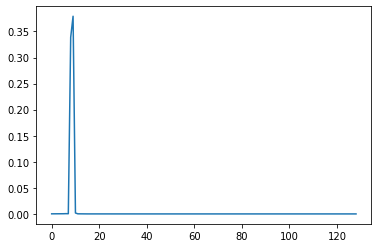

In [187]:
signal=pendulum_source[10,:N]
print(signal.size())
e=get_spec_col(signal)
print(e.size())
plt.plot(e)
plt.show()

In [188]:
#check: make a spectrogram with the torch fft for that we need a window function (the same as in my classical STFT)
def make_spec(y,N,ns):
    n_col=int((y.size(0)-N)/ns)
    spec=torch.zeros(int(N/2)+1,n_col)
    for i in range(n_col):
        spec[:,i]=get_spec_col(y[i*ns:N+i*ns])
    return spec


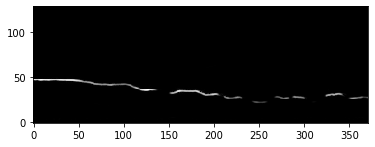

In [178]:
spec=make_spec(y,N,ns)
plt.imshow(np.log(spec.numpy()+1),origin='lower', cmap='gray')
plt.show()

In [89]:
model=nn.Linear(1,n_pendulum,bias=False)
dummy_input=torch.ones((1))
out=model(dummy_input)
print(out.size())

torch.Size([129])


In [303]:
def orchestra_step(spec_01,y_0,pendulum_source,model):
    #model=nn.Linear(1,spec_01.size(0),bias=False)
    N_2=y_0.size(0)
    N=pendulum_source.size(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    dummy_input=torch.ones((1))
    n_epochs=5000
    for i in range(n_epochs):
        a_1=torch.unsqueeze(model(dummy_input),1)
        loss_sparsity=torch.sum(torch.abs(a_1))
        y_hat=torch.sum(pendulum_source*a_1,axis=0)#broad casting
        #locality
        spec_loc=get_spec_col(y_hat)
        d_loc=torch.log(spec_loc+1)-torch.log(spec_01[:,1]+1)
        loss_loc=torch.sum(torch.mul(d_loc,d_loc))
        #consistency
        y_con=torch.cat((y_0,y_hat[N_2:]), 0)
        spec_con=get_spec_col(y_con)
        d_con=torch.log(spec_con+1)-torch.log(spec_01[:,0]+1)
        loss_con=torch.sum(torch.mul(d_con,d_con))
        loss=loss_loc+1*loss_con+0.1*loss_sparsity
        loss.backward()
        optimizer.step()
        if i%200==0:
            print(loss.item())
    print(loss.item())
    plt.plot(spec_loc.detach().numpy())
    plt.plot(spec_01[:,1])
    plt.show()
    #raise ValueError('asdf')
    
    return torch.squeeze(a_0.detach()),y_hat.detach(),model
    
def initialize(spec_0,pendulum_source_0):
    model=nn.Linear(1,spec_0.size(0),bias=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    dummy_input=torch.ones((1))
    n_epochs=1000
    for i in range(n_epochs):
        optimizer.zero_grad()
        a_0=torch.unsqueeze(model(dummy_input),1)
        loss_sparsity=0*torch.sum(torch.abs(a_0))
        y_hat_init=torch.sum(pendulum_source_0*a_0,axis=0)#broad casting
        spec_col=get_spec_col(y_hat_init)
        d=torch.log(spec_col+1)-torch.log(spec_0+1)
        loss_loc=torch.sum(torch.mul(d,d))
        loss=loss_loc+loss_sparsity
        loss.backward()
        optimizer.step()
    print(loss.item())
    plt.plot(spec_col.detach().numpy())
    plt.plot(spec_0)
    plt.show()
    #raise ValueError('asdf')
    
    return torch.squeeze(a_0.detach()),y_hat_init.detach(),model

ns: 80
N: 256
n_pendulum: 129
0.0025292246136814356


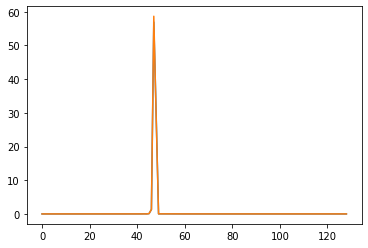

torch.Size([129])
step: 0/371
23.0516357421875
15.415616989135742
14.779674530029297
21.138221740722656
20.126821517944336
23.144439697265625
27.94803237915039
32.65557861328125
39.05487823486328
38.4503173828125
38.9730224609375
46.0871467590332
45.741416931152344
39.320613861083984
50.349456787109375
46.199256896972656
47.659305572509766
50.70677947998047
49.50081253051758
50.19137954711914
58.31028747558594
46.27097702026367
48.743629455566406
62.18296813964844
39.68812942504883
64.43073272705078


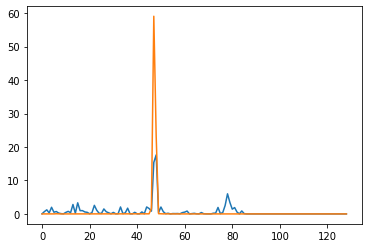

step: 1/371
87.64350891113281
55.22365188598633
53.198211669921875
58.60465621948242
56.9458122253418
60.10057067871094
59.04248046875
52.953433990478516
59.625885009765625
54.13227844238281
59.089378356933594
58.15638732910156
55.72684860229492
59.2291259765625


KeyboardInterrupt: 

In [302]:
if ns>=N/2:
    print('Warning: The step size is larger than half the window size.')
n_col=int((y.size(0)-N)/ns)
N_2=int(N/2)
print('ns: '+str(ns))
print('N: '+str(N))
print('n_pendulum: '+str(n_pendulum))
pendulum_source_t=torch.from_numpy(pendulum_source)
#calculate the true spectrogram
spec=torch.zeros(int(N/2)+1,n_col)
for i in range(n_col):
    spec[:,i]=get_spec_col(y[i*ns:N+i*ns])
approximate_signal=torch.zeros(y.size(0)).double()#here we store the found signal
pendulum_amplitudes=torch.zeros(n_pendulum,n_col)#here we store the found pendulum amplitudes
#approximate_signal[:N-ns]=y[:N-ns]
a_0,y_hat_init,model=initialize(spec[:,0],pendulum_source_t[:,:N])
print(a_0.size())
pendulum_amplitudes[:,0]=a_0
approximate_signal[:N]=y_hat_init
for i in range(n_col-1):
    print('step: '+str(i)+'/'+str(n_col))
    a_0,signal_step,model=orchestra_step(spec[:,i:i+2],approximate_signal[i*ns:N_2+i*ns],pendulum_source_t[:,(i+1)*ns:N+(i+1)*ns],model)
    approximate_signal[i*ns:N+i*ns]=signal_step
    pendulum_amplitudes[:,i+1]=a_0


In [ ]:
spec=make_spec(approximate_signal,N,ns)
plt.imshow(np.log(spec.numpy()+1),origin='lower', cmap='gray')
plt.show()